# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import cv2
import matplotlib.pyplot as plt
import os, glob, sys
import datetime
from skimage import transform, io, exposure, data

# from scipy.misc import imread, imresize # This code not working in current scipy version. We can install old version using (pip install scipy==1.1.0) but Let's use OpenCV instead

We set the random seed so that the results don't vary drastically.

In [2]:
import random as rn
from tensorflow.keras import backend as K
import tensorflow as tf

# set seed values 
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# file path , change it if your data is in different directory
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

(360, 360, 3)


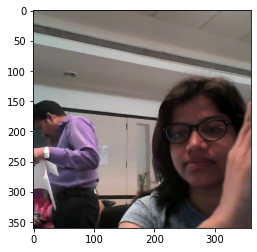

In [5]:
# checking a sample file

train_path = '/datasets/Project_data/train'
image = cv2.imread(train_path+'/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.imshow(image)

## 2. Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
# Data Augmentation Function
def data_augment(image_resize, idx):                   
    shift_x, shift_y = image_resize.shape[0]/2, image_resize.shape[1]/2   
    mat_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y]) #creating topleft dimensions
    mat_center = transform.SimilarityTransform(translation=[shift_x, shift_y])    #creating center dimensions
    if idx%8 == 0:
        trans_transform = transform.AffineTransform(translation=(20,50))
        trans_matrix = mat_topleft + trans_transform + mat_center
        image_resize = transform.warp(image_resize, trans_matrix)
    if idx%4 == 0:
        image_resize +=40

    if idx%6 == 0:
        image_resize +=10
        percentiles = np.percentile(image, (5, 95))
        scaled = exposure.rescale_intensity(image_resize, in_range=tuple(percentiles))

    return image_resize    

In [7]:
# Data generation in batches function
def generator(source_path, folder_list, batch_size, img_idx, dimensions, tr_type='train', aug='N'):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx # selcting only these indexed frames
    height, width = dimensions[0], dimensions[1]  # for image resize
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(np.floor(len(t)/batch_size))
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    dim = (width, height)
                    image_resize = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)

                    # Image Augmentation using skimage
                    if tr_type=='train' and aug=='Y':
                       image_resize = data_augment(image_resize, idx)

                    batch_data[folder,idx,:,:,0] = image_resize[:, :, 0]/255
                    batch_data[folder,idx,:,:,1] = image_resize[:, :, 1]/255
                    batch_data[folder,idx,:,:,2] = image_resize[:, :, 2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # code for the remaining data points which are left after full batches
        rem_data = t[batch_size*num_batches:]

        if len(rem_data) > 0:
            batch_data = np.zeros((len(rem_data), len(img_idx), height, width, 3))
            batch_labels = np.zeros((len(rem_data), 5))
            for folder in range(len(rem_data)):
                imgs = os.listdir(source_path+'/'+rem_data[folder].split(';')[0])
                for idx, item in enumerate(img_idx):
                  image = cv2.imread(source_path+'/'+rem_data[folder].split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                                  
                  dim = (width, height)
                  image_resize = cv2.resize(image, dim, interpolation = cv2.INTER_NEAREST)

                  # Image Augmentation using skimage
                  if tr_type=='train' and aug=='Y':
                     image_resize = data_augment(image_resize, idx)
                                  
                  batch_data[folder,idx,:,:,0] = image_resize[:, :, 0]/255
                  batch_data[folder,idx,:,:,1] = image_resize[:, :, 1]/255
                  batch_data[folder,idx,:,:,2] = image_resize[:, :, 2]/255

                batch_labels[folder, int(rem_data[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [8]:
# Instantiating important variables
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

batch_size = 30
height, width = 120, 160 # reduced image size from 260x260 to 120x160
channels = 3
img_classes = 5

# select specific frames of the video
img_idx = [2,4,6,8,10,12,14,15,16,18,19,22,24,26,28] # experimented with the number of frames and removed some frames

# training sequences = 663
# validation sequences = 100
# epochs = 30


## 3. Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
# Learning rate hyperparameter tuning

# range of learning rates to tune
lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()

### Model 1

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, AveragePooling3D, GlobalAveragePooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# can try activations - Leaky ReLU & Parametric ReLU (PReLU)

input = (len(img_idx), height, width, channels)

model_1 = Sequential([
                     Conv3D(16, 3, padding='same', activation='relu', input_shape=input),
                     BatchNormalization(),
                     Conv3D(16, 3, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=(2, 2, 2)),

                     Conv3D(32, 3, padding='same', activation='relu'),
                     BatchNormalization(),
                     Conv3D(32, 3, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=(2, 2, 2)),
    
                     Flatten(),

                     Dense(128, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.25),

                     Dense(img_classes, activation='softmax')
])

# compiling the model
optimiser = optimizers.Adam()
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

# Initializing the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx, dimensions=[height, width])
val_generator = generator(val_path, val_doc, batch_size, img_idx, dimensions=[height, width], tr_type='val')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 120, 160, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 120, 160, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 120, 160, 16)  6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 120, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 60, 80, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 60, 80, 32)     13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 60, 80, 32)     1

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_Conv3dGRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'modelConvGRU-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=2, verbose=1, mode="auto")

callbacks_list = [checkpoint, LR, history]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
# calculating number of batches
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Model 1 is overfitting

In [33]:
# Model.fit_generator is deprecated and will be removed in a future version. Using `Model.fit`, which supports generators.
model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - 23s 996ms/step - loss: 1.1933 - categorical_accuracy: 0.5837 - val_loss: 5.9244 - val_categorical_accuracy: 0.3300
Epoch 2/30
23/23 [==============================] - 22s 953ms/step - loss: 0.7175 - categorical_accuracy: 0.7300 - val_loss: 32.8498 - val_categorical_accuracy: 0.1600
Epoch 3/30
22/23 [===========================>..] - ETA: 0s - loss: 0.5293 - categorical_accuracy: 0.7924
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
23/23 [==============================] - 22s 950ms/step - loss: 0.5311 - categorical_accuracy: 0.7919 - val_loss: 28.4235 - val_categorical_accuracy: 0.2800
Epoch 4/30
23/23 [==============================] - 21s 922ms/step - loss: 0.3694 - categorical_accuracy: 0.8793 - val_loss: 17.6697 - val_categorical_accuracy: 0.3100
Epoch 5/30
22/23 [===========================>..] - ETA: 0s - loss: 0.1975 - categorical_acc

### Model 2

In [15]:
# building the model
model_2 = Sequential([
                     Conv3D(16, 3, padding='same', activation='relu', input_shape=input),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=(2, 2, 2), padding='same'),

                     Conv3D(32, 3, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=(2, 2, 2), padding='same'),
    
                     Conv3D(64, 3, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=(2, 2, 2), padding='same'),


                     Flatten(),
                     #GlobalAveragePooling3D(), 

                     Dense(256, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.20),

                     Dense(img_classes, activation='softmax')
])

print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 120, 160, 16)  1312      
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 120, 160, 16)  64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 60, 80, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 80, 32)     13856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 60, 80, 32)     128       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 4, 30, 40, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 4, 30, 40, 64)    

In [14]:
# compiling the model
optimiser = optimizers.Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# initializing the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx, dimensions=[height, width])
val_generator = generator(val_path, val_doc, batch_size, img_idx, dimensions=[height, width], tr_type='val')

# running the model
model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.0935 - categorical_accuracy: 0.6365Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_Conv3d_2021-08-0120_04_55.066204/modelConv3d-00001-1.09350-0.63650-3.05796-0.19000.h5
23/23 [==============================] - 29s 1s/step - loss: 1.0935 - categorical_accuracy: 0.6365 - val_loss: 3.0580 - val_categorical_accuracy: 0.1900
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.3693 - categorical_accuracy: 0.8718
Epoch 00002: saving model to model_init_Conv3d_2021-08-0120_04_55.066204/modelConv3d-00002-0.36931-0.87179-6.86690-0.26000.h5
23/23 [==============================] - 29s 1s/step - loss: 0.3693 - categorical_accuracy: 0.8718 - val_loss: 6.8669 - val_categorical_accuracy: 0.2600
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.2070 - categorical_accuracy: 0.9261
Ep

In [49]:
# Using Augmentation

# compiling the model
optimiser = optimizers.Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# initializing the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx, dimensions=[height, width], aug='Y')
val_generator = generator(val_path, val_doc, batch_size, img_idx, dimensions=[height, width], tr_type='val')

# running the model
model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
22/23 [===========================>..] - ETA: 1s - loss: 0.3547 - categorical_accuracy: 0.8682
Epoch 00001: saving model to model_init_Conv3dAug_2021-08-0120_59_54.176177/modelConv3d-00001-0.35362-0.86878-5.16921-0.40000.h5
23/23 [==============================] - 38s 2s/step - loss: 0.3536 - categorical_accuracy: 0.8688 - val_loss: 5.1692 - val_categorical_accuracy: 0.4000
Epoch 2/30
22/23 [===========================>..] - ETA: 1s - loss: 0.1104 - categorical_accuracy: 0.9697
Epoch 00002: saving model to model_init_Conv3dAug_2021-08-0120_59_54.176177/modelConv3d-00002-0.11745-0.96833-6.31200-0.31000.h5
23/23 [==============================] - 37s 2s/step - loss: 0.1174 - categorical_accuracy: 0.9683 - val_loss: 6.3120 - val_categorical_accuracy: 0.3100
Epoch 3/30
22/23 [===========================>..] - ETA: 1s - loss: 0.1602 - categorical_accuracy: 0.9470
Epoch 00003: saving model to model_init_Conv3dAug_2021-0

### Model 3 - ConvLSTM

In [18]:
# building the model
model_3 = Sequential([
                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),

                LSTM(128),
                Dropout(0.20),

                Dense(128,activation='relu'),
                Dropout(0.20),

                Dense(img_classes, activation='softmax')
])

print(model_3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 120, 160, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 120, 160, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 60, 80, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 60, 80, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 60, 80, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 30, 40, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 30, 40, 64)   

In [19]:
# compiling the model
optimiser = optimizers.Adam()
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# initializing the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx, dimensions=[height, width])
val_generator = generator(val_path, val_doc, batch_size, img_idx, dimensions=[height, width], tr_type='val')

# running the model
model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
22/23 [===========================>..] - ETA: 1s - loss: 1.3942 - categorical_accuracy: 0.4061Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_Conv3dLSTM_2021-08-0202_29_41.178215/modelConvLSTM-00001-1.39411-0.40724-1.68377-0.25000.h5
23/23 [==============================] - 30s 1s/step - loss: 1.3941 - categorical_accuracy: 0.4072 - val_loss: 1.6838 - val_categorical_accuracy: 0.2500
Epoch 2/30
22/23 [===========================>..] - ETA: 1s - loss: 0.9434 - categorical_accuracy: 0.6667
Epoch 00002: saving model to model_init_Conv3dLSTM_2021-08-0202_29_41.178215/modelConvLSTM-00002-0.94210-0.66667-1.79277-0.22000.h5
23/23 [==============================] - 29s 1s/step - loss: 0.9421 - categorical_accuracy: 0.6667 - val_loss: 1.7928 - val_categorical_accuracy: 0.2200
Epoch 3/30
22/23 [===========================>..] - ETA: 1s - loss: 0.7307 - categorical_accurac

### Model 4 - ConvGRU

In [16]:
# building the model
model_4 = Sequential([
                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),

                GRU(128),
                Dropout(0.20),

                Dense(128,activation='relu'),
                Dropout(0.20),

                Dense(img_classes, activation='softmax')
])

print(model_4.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 120, 160, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 15, 120, 160, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 15, 60, 80, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 60, 80, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 60, 80, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 30, 40, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 30, 40, 64)   

In [17]:
# compiling the model
optimiser = optimizers.Adam()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# initializing the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx, dimensions=[height, width])
val_generator = generator(val_path, val_doc, batch_size, img_idx, dimensions=[height, width], tr_type='val')

# running the model
model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4846 - categorical_accuracy: 0.3665Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_Conv3dGRU_2021-08-0212_54_58.181126/modelConvGRU-00001-1.48457-0.36652-1.73212-0.25000.h5
23/23 [==============================] - 33s 1s/step - loss: 1.4846 - categorical_accuracy: 0.3665 - val_loss: 1.7321 - val_categorical_accuracy: 0.2500
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.0223 - categorical_accuracy: 0.5988
Epoch 00002: saving model to model_init_Conv3dGRU_2021-08-0212_54_58.181126/modelConvGRU-00002-1.02225-0.59879-1.86637-0.23000.h5
23/23 [==============================] - 32s 1s/step - loss: 1.0223 - categorical_accuracy: 0.5988 - val_loss: 1.8664 - val_categorical_accuracy: 0.2300
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.8177 - categorical_accuracy: 0